# Cleaned Analysis of May 28th Linus Flight
## Purpose
* Use the methods same as CREATeV to reduce acceleration data
* Comment on the results, making a few conclusions
## Methods
Acceleration without any IMU Compensation
## Results

## Naming and Folders

In [1]:
### Definining name of analysis ###
name = '2023-05-28_Linus_Acceleration_Analysis_Cleaned'
data_path = '../../data/'
data_folder = 'linus-2023-05-26'
file_name = '00000009.BIN'
datasave_path = data_path+data_folder+'/'
result_path = '../Results/'+name+'/'
figure_path = '../Figures/'+name+'/'

## Importing Libraries and Packages

In [2]:
# Getting packages #
from os import sys
import os
sys.path.append('../../')

%matplotlib widget

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import plotly.express as px

import main
import propellers
import motors
from aircraft import airplane
import cl_finders

### Creating Folders for Results/Data ###
if not os.path.exists(result_path):
    os.makedirs(result_path)
if not os.path.exists(figure_path):
    os.makedirs(figure_path)
    
# Setting Plot Defaults
plt.style.use('../../basic_plotter.mplstyle')

## Importing Data

In [3]:
rate = "10ms"
interpolateM = "linear"
processor = "ArduPlane_4_3_3"
df = main.data_load(data_path, data_folder, file_name, rate, interpolateM, processor)

In [4]:
build_turbulent = pd.read_pickle("../../DragBuilds/Linus_DragBuildTurbulent.pkl")
build_laminar = pd.read_pickle("../../DragBuilds/Linus_DragBuildLaminar.pkl")

## Defining Vehicle Parameters

In [5]:
# Vehicle parameters
prop = propellers.aeronaut11x7_estimatedBEN() # Using aeronaut 20x8 for this flight
motor = motors.U7V2_280KV()  # Using U7 V2 motor

mass = 1.793
span = 2.54
chord = 0.149
linus = airplane(mass, chord, span)
linus.area = 0.367
linus.AR = 17.583

# Manually Selecting Masks by Plots

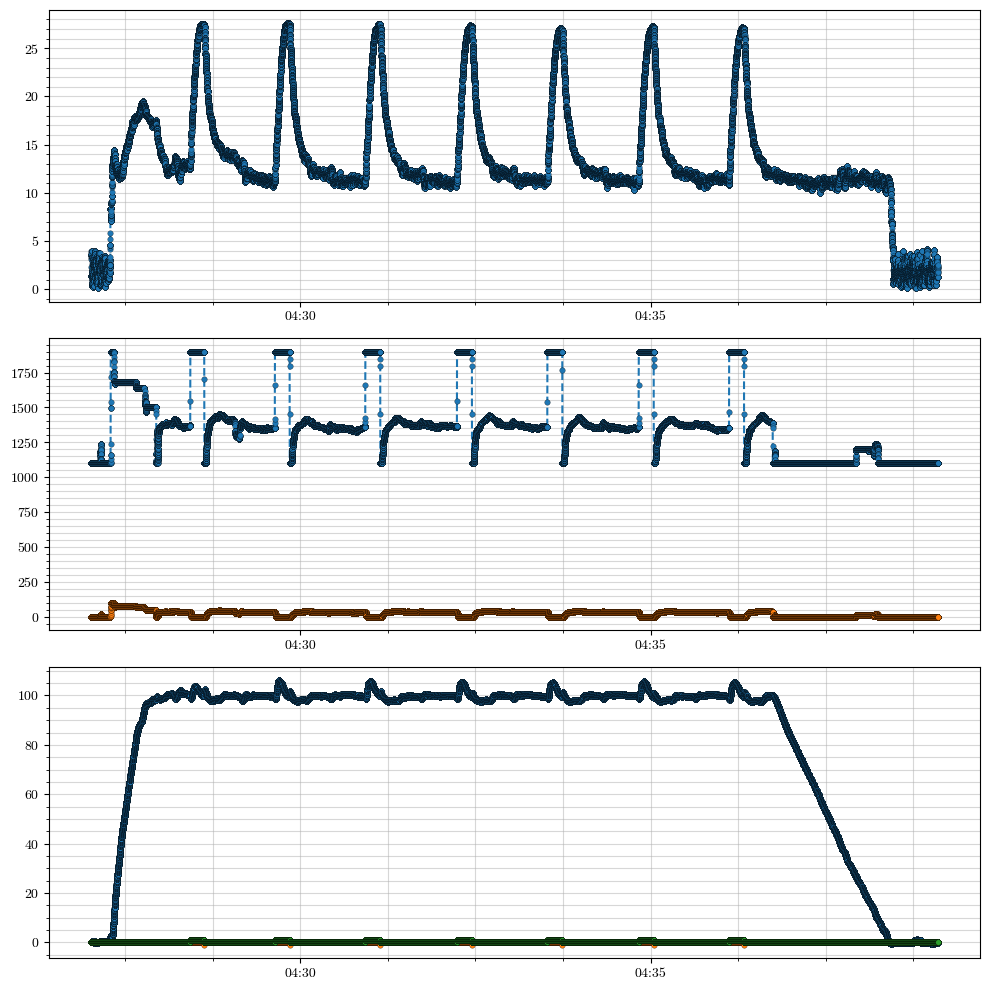

In [6]:
# Generating Plots
bin_mask = (df['ThrottleOut'] == 1900) & (df['MainBatteryCurrent'] >= 5) & (df['Throttle'] != 100) & (df['Altitude_BARO_0'] > 50)
jump = np.diff(np.int8(bin_mask))
start_mask = jump > 0
end_mask = jump < 0
start_indices = np.where(start_mask)
end_indices = np.where(end_mask)

start_times = df.index[start_indices]
end_times = df.index[end_indices]

plt.figure(figsize=(10,10))
ax0 = plt.subplot(3,1,1)
plt.grid("On")
plt.plot(df.index, df.Airspeed_Sensor0, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
ax1 = plt.subplot(3,1,2, sharex=ax0)
plt.grid("On")
plt.plot(df.index, df.ThrottleOut, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
plt.plot(df.index, df.Throttle, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
ax2 = plt.subplot(3,1,3, sharex=ax0)
plt.grid("On")
plt.plot(df.index, df.Altitude_BARO_0, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
plt.plot(df.index[0:-1,], jump, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
plt.plot(df.index, bin_mask, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
plt.grid("On")
plt.show()

## Results of Manual Segmentation
### Acceleration Segmentation

In [7]:
### Mask Initialization ###
year = 2023
month = 5
day = 27

seg_times = np.array([['04:28:27','04:28:37'],
                      ['04:29:39','04:29:50'],
                      ['04:30:57','04:31:08'],
                      ['04:32:15','04:32:27'],
                      ['04:33:33','04:33:44'],
                      ['04:34:51','04:35:02'],
                      ['04:36:08','04:36:20']
                      ])

masks = cl_finders.get_maskarray(df, seg_times, year, month, day)

## Checking Segments for Good Data

In [18]:
############# Main Analysis ###############3

# Gravity
g = 9.807

# Attitude 
phi = np.deg2rad(df["RollAngle"].to_numpy())            # Bank angle in radians
theta = np.deg2rad(df["PitchAngle"].to_numpy())         # Pitch angle in radians

# Atmospheric adjustments:
rho = df["Pressure_BARO0"].to_numpy() * (287 * (df["Temperature_ARSP"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
v_eas = df["Airspeed_Sensor0"].to_numpy()                               # Equivalent SSL airspeed (m/s)
v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
q = 0.5 * rho * v_tas**2                            # Dynamic pressure 

# For Descent method
h = df["Altitude_POS"].to_numpy()                   # Altitude
Vd_eas = df["DescentRate"].to_numpy()                  # Descent Rate from EKF (is it true or EAS at SSL?)
Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed

# Propulsion characterization
n = df["MotorRPM"].to_numpy() / 60                               # Revolutions per second
i_esc = df["MainBatteryCurrent"].to_numpy()                      # Really the ESC voltage and current here
v_esc = df["MainBatteryVoltage"].to_numpy()
J = v_tas / (n * prop.diameter)
eff = prop.efficiency(J) * motor.efficiency(n, i_esc)

# Inertial Measurement Unit
xp_acc = df["XAcc_IMU0"].to_numpy()                       # Acceleration in X direction of the IMU
yp_acc = df["YAcc_IMU0"].to_numpy()                       # Acceleration in Y direction of the IMU
zp_acc = df["ZAcc_IMU0"].to_numpy()                       # Acceleration in Z direction of the IMU

U_dot = xp_acc - 9.807 * np.sin(theta)
W_dot = zp_acc + 9.807 * np.cos(theta) * np.cos(phi)

gamma = np.arcsin(-Vd_tas/v_tas)
alpha = theta - gamma

U = v_tas * np.cos(alpha)
V = 0
W = v_tas * np.sin(alpha)

P = df.GyroX_IMU0 
Q = df.GyroY_IMU0
R = df.GyroZ_IMU0

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_26244/1988416842.py:11: RuntimeWarning: invalid value encountered in reciprocal
  rho = df["Pressure_BARO0"].to_numpy() * (287 * (df["Temperature_ARSP"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_26244/1988416842.py:13: RuntimeWarning: invalid value encountered in reciprocal
  v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_26244/1988416842.py:19: RuntimeWarning: invalid value encountered in reciprocal
  Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/22_Cleaned_Linus_Performance_Analysis/../../motors.py:53: RuntimeWarning: invalid value encountered in reciprocal
  efficiency = (1 - (i0/current)) * (Kv/Kq) * (1 + tau*omega +

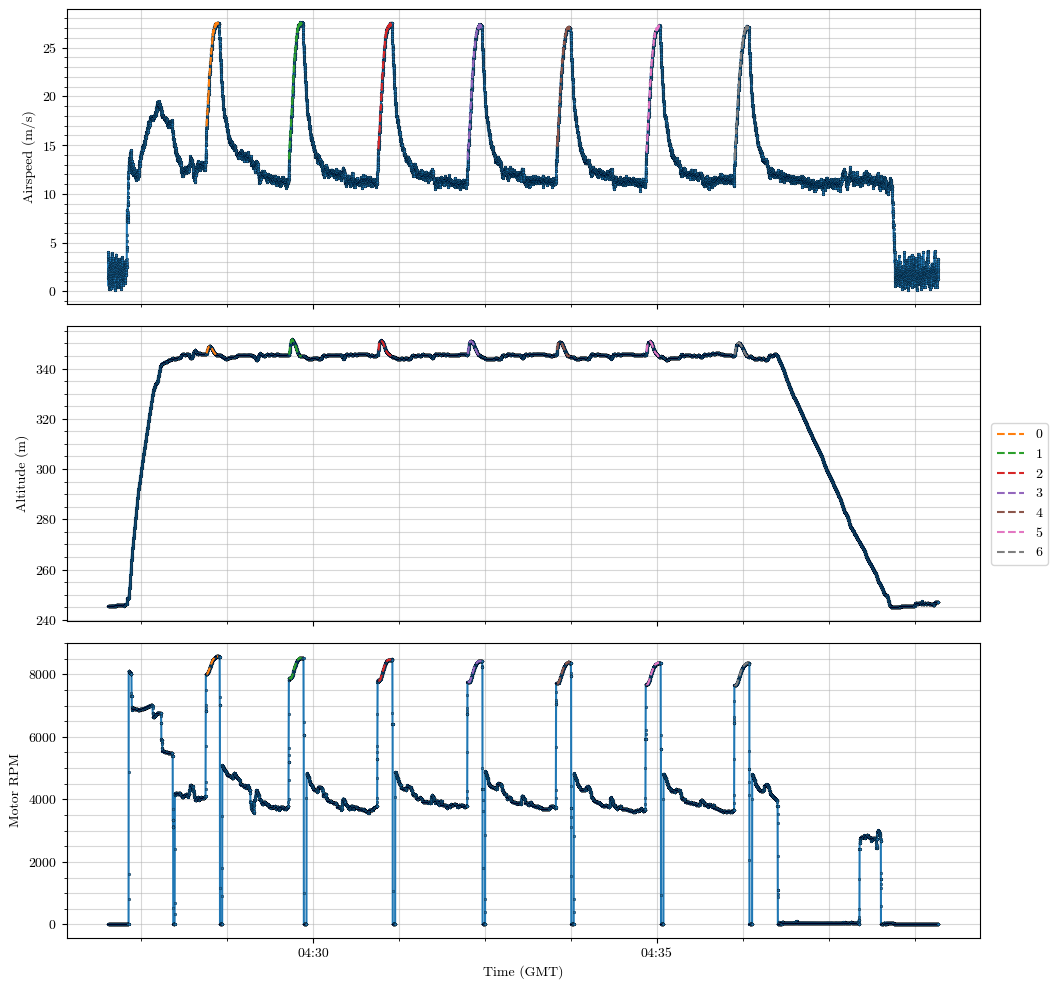

In [19]:
# Airspeed for Segments
[timeindex_v_h_RPM_fullsegmented, axs] = plt.subplots(3,1, sharex=True, figsize=(10,10), dpi=100)
# timeindex_v_h_RPM_segmented.subplots_adjust(right=0.2, left=0.1)

axs[0].plot(df.index, df.Airspeed_Sensor0)
for i in np.arange(len(masks)):
    axs[0].plot(df.Airspeed_Sensor0[masks[i]], marker='', linestyle='--', label=str(i) + "")
axs[0].set_ylabel("Airspeed (m/s)")

# Altitude for Segments
axs[1].plot(df.index, df.Altitude_POS)
for i in np.arange(len(masks)):
    axs[1].plot(df.Altitude_POS[masks[i]], marker='', linestyle='--')#, label=str(i) + "")
axs[1].set_ylabel("Altitude (m)")
# axs[1].legend(loc='center left',
#           ncol=2, fancybox=True, bbox_to_anchor=(1.04, 0.5))

# RPM for Segments
axs[2].plot(df.index, df.MotorRPM)
for i in np.arange(len(masks)):
    axs[2].plot(df.MotorRPM[masks[i]], marker='', linestyle='--')#, label=str(i) + "")
axs[2].set_ylabel("Motor RPM")
axs[2].set_xlabel("Time (GMT)")

timeindex_v_h_RPM_fullsegmented.legend(loc=7, bbox_to_anchor=(1.06, 0.5))
#timeindex_v_segmented.tight_layout(rect=[0, 0, 1.2, 1.2])
plt.show()
main.save_figure(timeindex_v_h_RPM_fullsegmented, f'{timeindex_v_h_RPM_fullsegmented=}'.split('=')[0], figure_path)

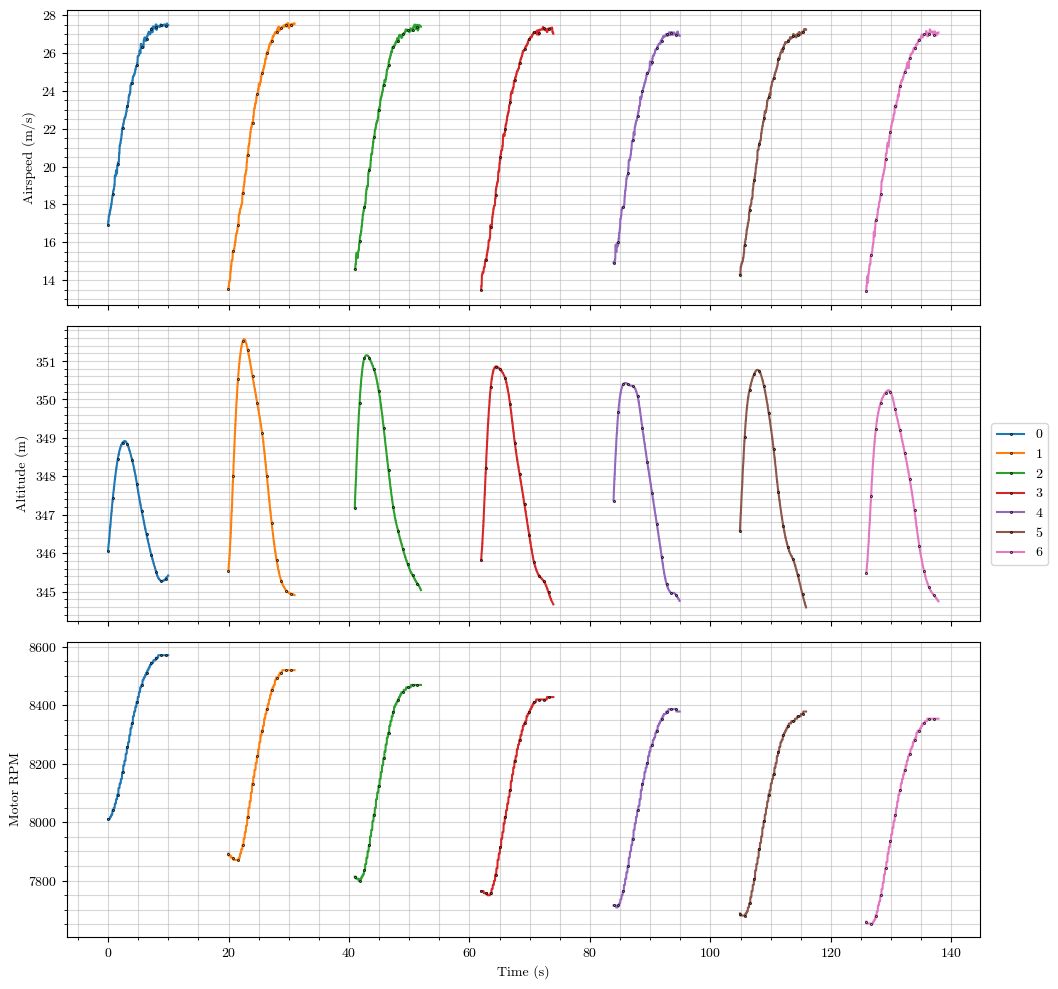

In [20]:
# Airspeed for Segments
[timeindex_v_h_RPM_segmented, axs] = plt.subplots(3,1, sharex=True, figsize=(10,10), dpi=100)
# timeindex_v_h_RPM_segmented.subplots_adjust(right=0.2, left=0.1)

markerevery=80
markedgew=0.5
t_init = 0
dT = 0.01
for i in range(len(masks)):
    segment_length = len(v_tas[masks[i]])            # Integer segment length
    time_s = np.linspace(t_init, (segment_length-1)*dT + t_init, segment_length)
    # Airspeed for Segments
    axs[0].plot(time_s, df.Airspeed_Sensor0[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew,label=str(i) + "")
    # Altitude for Segments
    axs[1].plot(time_s, df.Altitude_POS[masks[i]], linestyle='-' , markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)#, label=str(i) + "")
    # RPM for Segments
    axs[2].plot(time_s, df.MotorRPM[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)#, label=str(i) + "")
    t_init = time_s[-1]+10
axs[0].set_ylabel("Airspeed (m/s)")
axs[1].set_ylabel("Altitude (m)")
axs[2].set_ylabel("Motor RPM")
axs[2].set_xlabel("Time (s)")

timeindex_v_h_RPM_segmented.legend(loc=7, bbox_to_anchor=(1.06, 0.5))
#timeindex_v_segmented.tight_layout(rect=[0, 0, 1.2, 1.2])
plt.show()
main.save_figure(timeindex_v_h_RPM_segmented, f'{timeindex_v_h_RPM_segmented=}'.split('=')[0], figure_path)

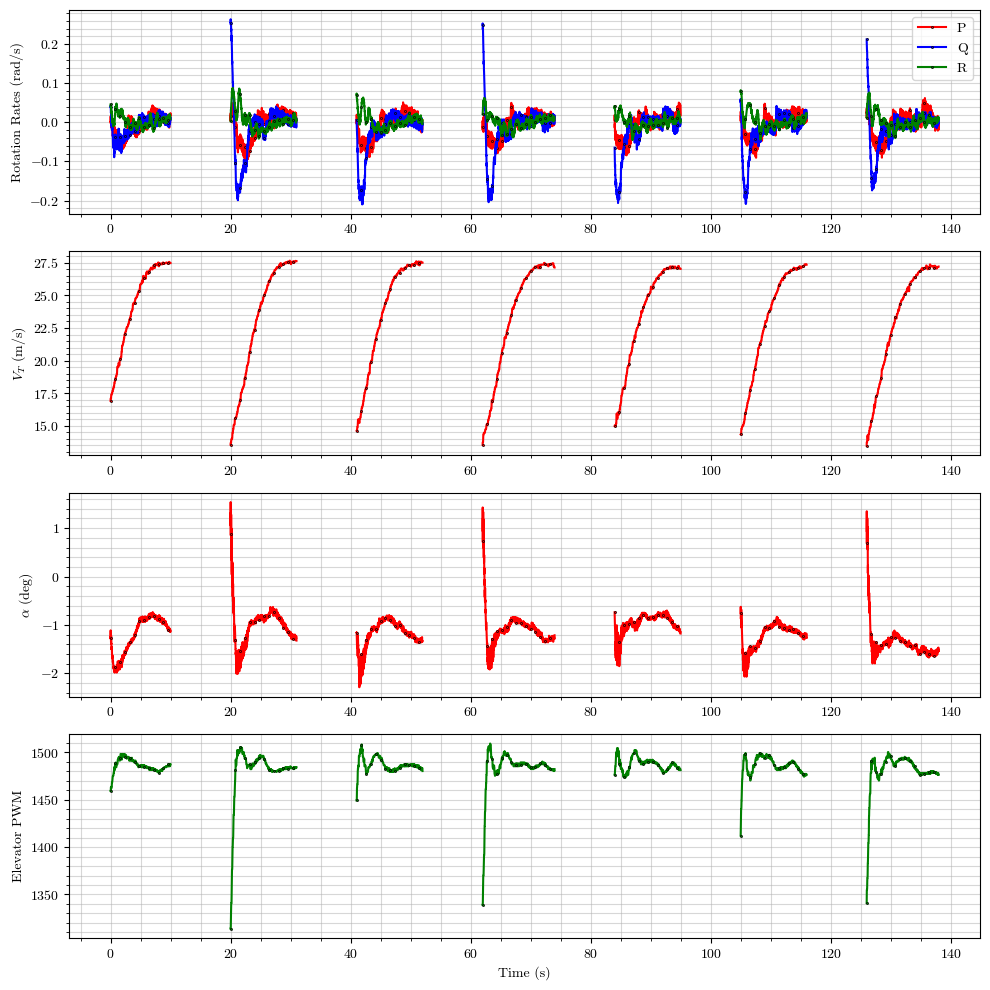

In [21]:
timeindex_PQR_V_alpha_PWM_segmented = plt.figure(figsize=(10,10))
plt.tight_layout()
t_init = 0
markerevery=80
markedgew=0.5

ax1 = plt.subplot(4,1,1)
ax2 = plt.subplot(4,1,2, sharex=ax1)
ax3 = plt.subplot(4,1,3, sharex=ax1)
ax4 = plt.subplot(4,1,4, sharex=ax1)
for i in range(len(masks)):
    dT = 0.01
    segment_length = len(v_tas[masks[i]])            # Integer segment length
    time_s = np.linspace(t_init, (segment_length-1)*dT + t_init, segment_length)
    ax1.plot(time_s, P[masks[i]], color='r', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, label='P')
    ax1.plot(time_s, Q[masks[i]], color='b', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, label='Q')
    ax1.plot(time_s, R[masks[i]], color='g', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, label='R')
    if i == 0:
        ax1.legend()
    ax1.set_ylabel("Rotation Rates (rad/s)")
    ax2.plot(time_s, v_tas[masks[i]], color='r', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    ax2.set_ylabel("$V_T$ (m/s)")
    ax3.plot(time_s, np.rad2deg(alpha[masks[i]]), color='r', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    ax3.set_ylabel("$\\alpha$ (deg)")
    ax4.plot(time_s, df.ElevatorOut[masks[i]], color='g', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    ax4.set_ylabel("Elevator PWM")
    ax4.set_xlabel("Time (s)")
    t_init = time_s[-1]+10
plt.show()
main.save_figure(timeindex_PQR_V_alpha_PWM_segmented, f'{timeindex_PQR_V_alpha_PWM_segmented=}'.split('=')[0], figure_path)

## Main Analysis for P_req

In [24]:
# Beginning Power Required Calculation without IMU Orientation Adjustment

CT = prop.thrust_coeff(J)
T = CT * rho * n**2 * prop.diameter**4

P_req_t1 = (T * v_tas)
P_req_t2 = (mass * g * Vd_tas)
P_req_t3 = -(mass * U_dot * v_tas)
P_req_t4 = -(mass * W_dot * v_tas * alpha)
P_req_t5 = mass * v_tas * (Q*U*alpha - Q*W)
P_req_t6 = mass * v_tas * (R*V - P*V)

P_req_simple = P_req_t1 + P_req_t2 + P_req_t3
P_req_wdot = P_req_t1 + P_req_t2 + P_req_t3 + P_req_t4
P_req_rates = P_req_t1 + P_req_t2 + P_req_t3 + P_req_t4 + P_req_t5 + P_req_t6

D_simple = P_req_simple / v_tas
D_wdot = P_req_wdot / v_tas
D_rates = P_req_rates / v_tas

CD_simple = D_simple / (0.5 * rho * v_tas**2 * linus.area) # still need to estimate the wing area of createv
CD_wdot = D_wdot / (0.5 * rho * v_tas**2 * linus.area) # still need to estimate the wing area of createv
CD_rates = D_rates / (0.5 * rho * v_tas**2 * linus.area) # still need to estimate the wing area of createv

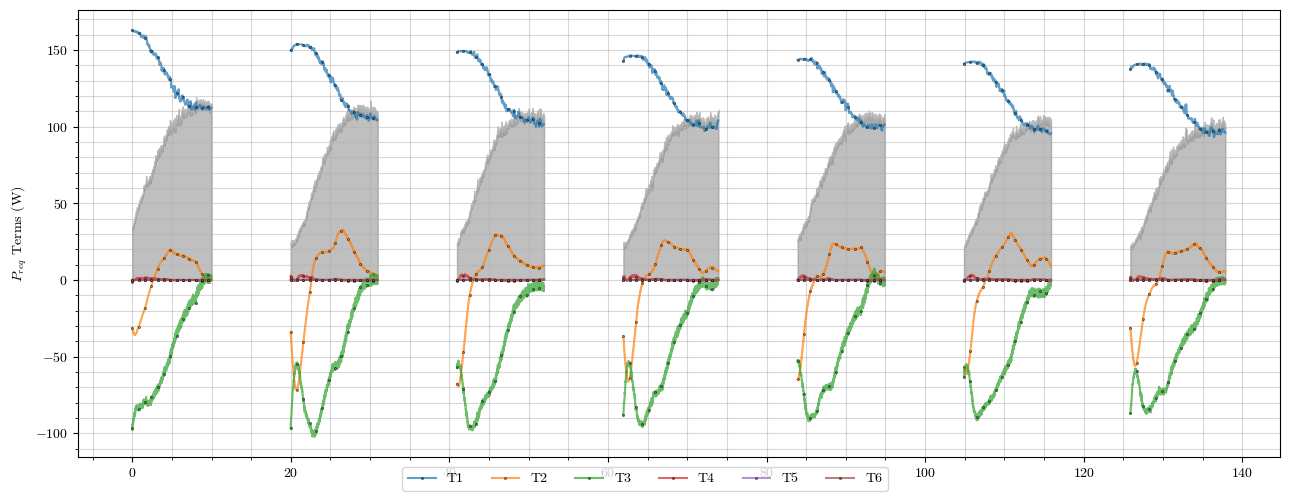

In [25]:
# Power Required Terms Comparison
[tiemindex_Preq_segmented, axs] = plt.subplots(1,1, sharex=True, figsize=(13,5), dpi=100)
# timeindex_v_h_RPM_segmented.subplots_adjust(right=0.2, left=0.1)

markerevery=80
markedgew=0.5
t_init = 0
dT = 0.01
for i in range(len(masks)):
    segment_length = len(v_tas[masks[i]])            # Integer segment length
    time_s = np.linspace(t_init, (segment_length-1)*dT + t_init, segment_length)
    # Airspeed for Segments
    axs.plot(time_s, P_req_t1[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#1f77b4', alpha=0.7)
    axs.plot(time_s, P_req_t2[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#ff7f0e', alpha=0.7)
    axs.plot(time_s, P_req_t3[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#2ca02c', alpha=0.7)
    axs.plot(time_s, P_req_t4[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#d62728', alpha=0.7)
    axs.plot(time_s, P_req_t5[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#9467bd', alpha=0.7)
    axs.plot(time_s, P_req_t6[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#8c564b', alpha=0.7)
    axs.fill_between(time_s, np.zeros(np.shape(P_req_wdot[masks[i]])), P_req_wdot[masks[i]], color='grey', alpha=0.5)
    t_init = time_s[-1]+10

tiemindex_Preq_segmented.legend(["T1", "T2", "T3", "T4", "T5", "T6"], loc='lower center', ncol=6)
axs.set_ylabel("$P_{req}$ Terms (W)")

plt.show()
main.save_figure(tiemindex_Preq_segmented, f'{tiemindex_Preq_segmented=}'.split('=')[0], figure_path)

## Lift Measurement

In [27]:
L_t1 = linus.weight * np.ones(np.shape(W_dot))
L_t2 = -1*(linus.mass * W_dot)
L_t3 = -1*(alpha*T)
L_t4 = alpha*linus.mass*U_dot

L_simple = L_t1 + L_t2
L_full = L_t1 + L_t2 + L_t3 + L_t4

CL_simple = L_simple / (0.5 * rho * v_tas**2 * linus.area)
CL_full = L_full / (0.5 * rho * v_tas**2 * linus.area)
# CL = cl_finders.cl_usbanked(createv, q, phi, W_dot)

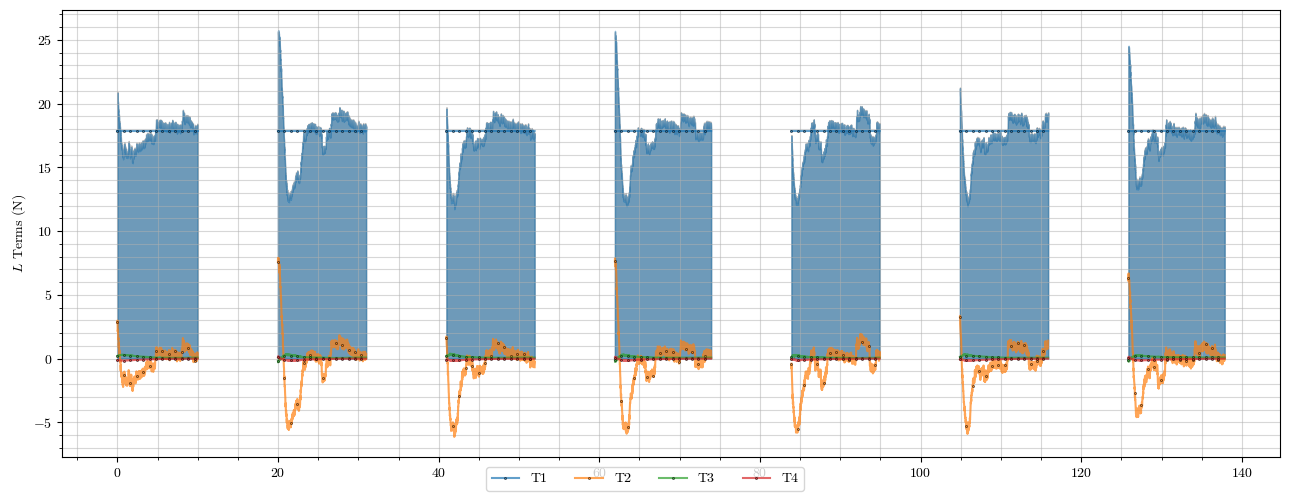

In [28]:
# Lift Term Comparison
[fig, axs] = plt.subplots(1,1, sharex=True, figsize=(13,5), dpi=100)
# timeindex_v_h_RPM_segmented.subplots_adjust(right=0.2, left=0.1)

markerevery=80
markedgew=0.5
t_init = 0
dT = 0.01
for i in range(len(masks)):
    segment_length = len(v_tas[masks[i]])            # Integer segment length
    time_s = np.linspace(t_init, (segment_length-1)*dT + t_init, segment_length)
    # Airspeed for Segments
    axs.plot(time_s, L_t1[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#1f77b4', alpha=0.7)
    axs.plot(time_s, L_t2[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#ff7f0e', alpha=0.7)
    axs.plot(time_s, L_t3[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#2ca02c', alpha=0.7)
    axs.plot(time_s, L_t4[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#d62728', alpha=0.7)
    axs.fill_between(time_s, np.zeros(np.shape(L_full[masks[i]])), L_full[masks[i]], color='grey', alpha=0.5)
    axs.fill_between(time_s, np.zeros(np.shape(L_simple[masks[i]])), L_simple[masks[i]], color='#1f77b4', alpha=0.5)
    t_init = time_s[-1]+10

fig.legend(["T1", "T2", "T3", "T4"], loc='lower center', ncol=6)
axs.set_ylabel("$L$ Terms (N)")

plt.show()
# main.save_figure(timeindex_v_h_RPM_segmented, f'{timeindex_v_h_RPM_segmented=}'.split('=')[0], figure_path)

## Collecting Total Results for Polar

In [29]:
# Collecting Total CL, CD's
cl_total = cl_finders.total_segments_boolean(CL_simple, masks)
cd_total = cl_finders.total_segments_boolean(CD_wdot, masks)

## Binning Total Results for Polar

In [34]:
bins = np.linspace(0.05, 1.4, 50)
[cl_bin_means, cl_bin_stds, cl_bin_ci95s, cd_bin_means, cd_bin_stds, cd_bin_ci95s] = cl_finders.collect_bins(np.linspace(0.1, 1.1, 50), cl_total, cd_total)

/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/22_Cleaned_Linus_Performance_Analysis/../../cl_finders.py:415: RuntimeWarning: Mean of empty slice.
  cl_means = [total_lift_coeffs[digitized == i].mean() for i in range(1, len(bins))]
/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.10/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/pyt

## Plotting Results of Binning

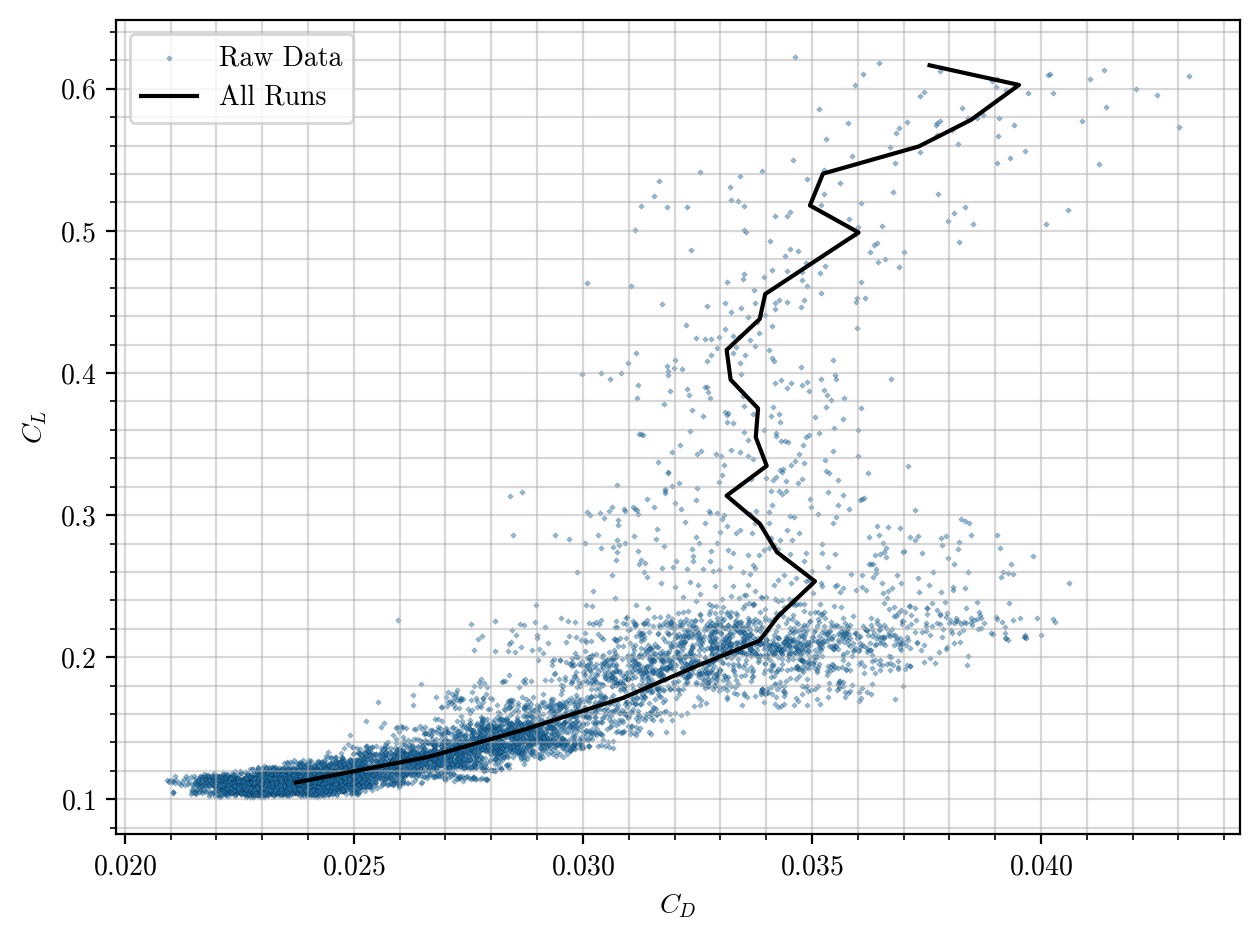

Plot already exists


In [35]:
fig_dragpolar = plt.figure(dpi=200)
plt.scatter(cd_total, cl_total, marker='D', alpha=0.5, edgecolors=[0,0,0], s=2, linewidths=0.1, label='Raw Data')
plt.plot(cd_bin_means, cl_bin_means, marker='', markeredgecolor=[0,0,0], markersize=5, markeredgewidth=markedgew, linestyle='-', color='black', label='All Runs')
plt.legend()
plt.xlabel("$C_D$")
plt.ylabel("$C_L$")
plt.show()
main.save_figure(fig_dragpolar, f'{fig_dragpolar=}'.split('=')[0], figure_path)

## Performing Curve Fits to Find Polars

In [51]:
polar_acceleration = cl_finders.cd2polar(linus, cd_total, cl_total, highorder=False)
print(polar_acceleration)

-2.9554996800870454
[0.02568542 0.3901658 ]


## Packaging the Results

In [53]:
acceleration_binresult = cl_finders.packaging_binresults(cl_total, cl_bin_means, cl_bin_stds, cl_bin_ci95s, cd_total, cd_bin_means, cd_bin_stds, cd_bin_ci95s, polar_acceleration, linus)

## Saving Results to Disk

In [54]:
# Exporting polar data
pd.to_pickle(acceleration_binresult, result_path+'acceleration_allresult.pkl')

## Additional Plots

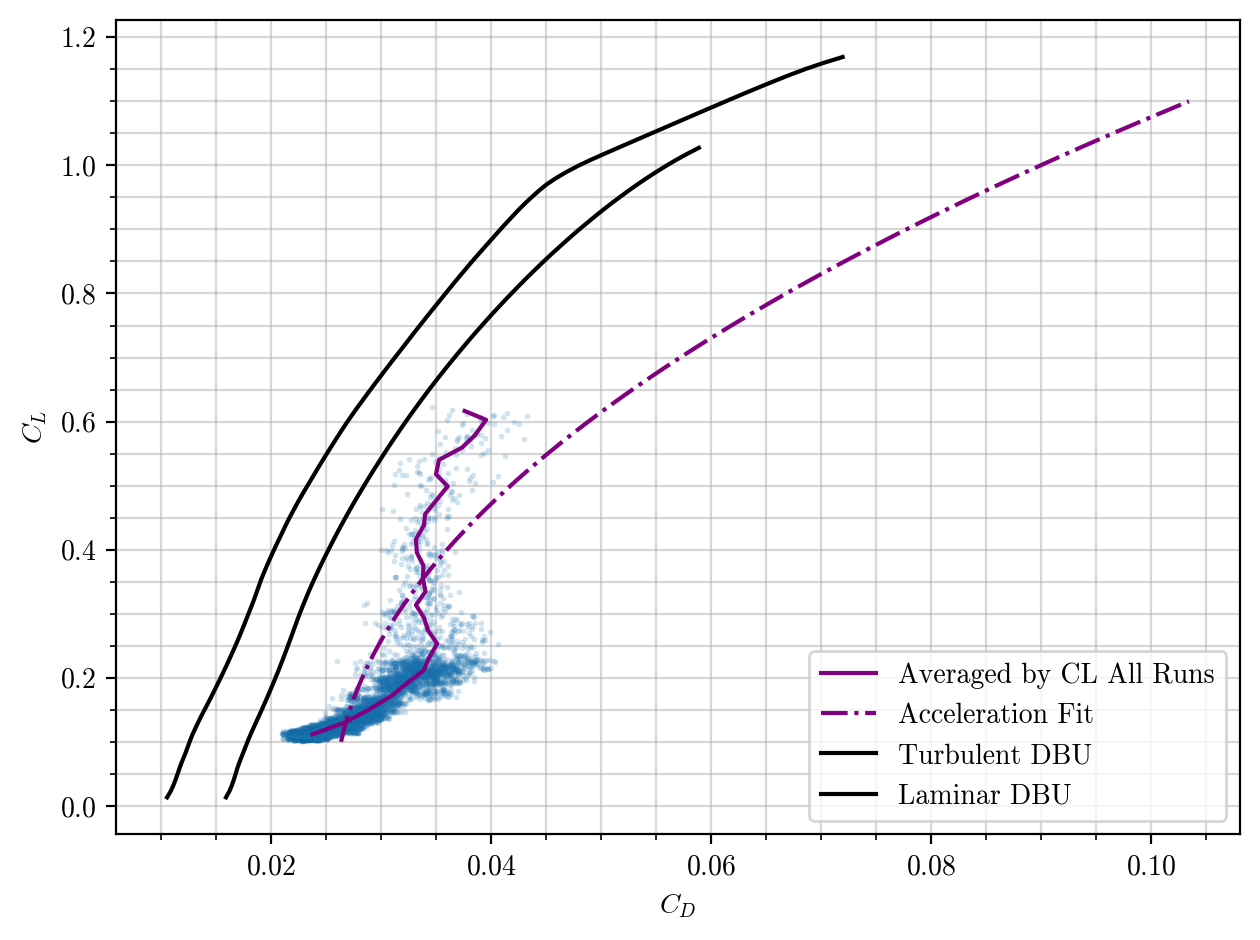

Plot already exists


In [66]:
fig_dragpolar_context = plt.figure(dpi=200)

plt.plot(cd_total, cl_total, marker="o", markersize=2, markeredgewidth=0.01, markeredgecolor='black', linestyle='', alpha=0.2)
plt.plot(cd_bin_means, cl_bin_means, marker='', color='purple', markeredgecolor=[0,0,0], markersize=5, markeredgewidth=markedgew, linestyle='-', label='Averaged by CL All Runs')

plt.plot(CD_fitted_ACC, CL_fitted_ACC, marker='', color='purple', linestyle='-.', label="Acceleration Fit")

plt.plot(build_turbulent.CD[:106], build_turbulent.CL[:106], marker='', color='black', linestyle='solid', label="Turbulent DBU")
plt.plot(build_laminar.CD, build_laminar.CL, marker='', color='black', linestyle='solid', label="Laminar DBU")

plt.legend()
plt.xlabel("$C_D$")
plt.ylabel("$C_L$")
plt.show()
main.save_figure(fig_dragpolar_context, f'{fig_dragpolar_context=}'.split('=')[0], figure_path)

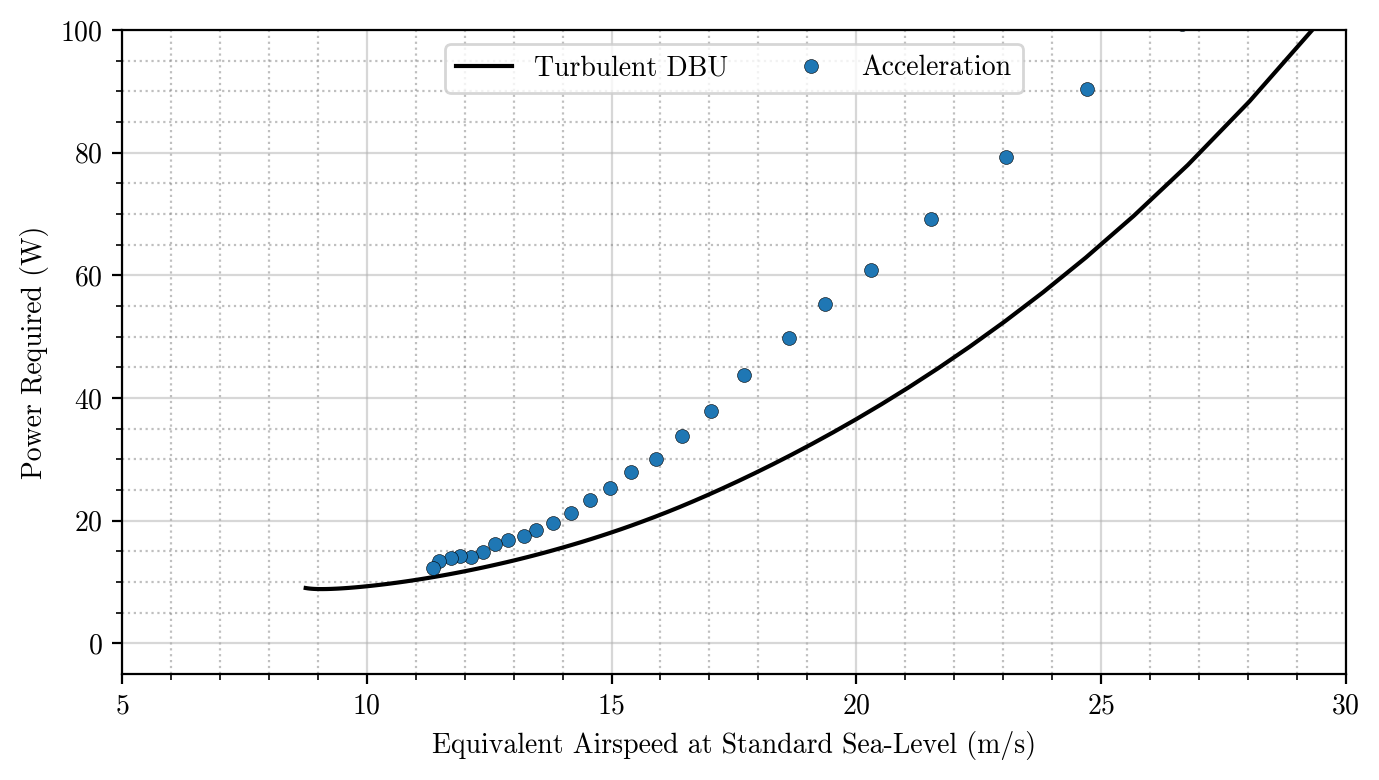

In [75]:
# Plot of Power Required Fits and Data #

[Pbin_acc, EAS_acc] = cl_finders.rawpolar2preqew(linus, cl_bin_means, cd_bin_means)
[P_dbu, EAS_dbu] = cl_finders.rawpolar2preqew(linus, build_turbulent.CL, build_turbulent.CD)

fig_Preq_context = plt.figure(figsize=(7,4), dpi=200)
plt.errorbar(EAS_acc, Pbin_acc, label="Acceleration", linestyle='', marker='o', markersize=5)
plt.plot(EAS_dbu, P_dbu, marker='', color='black', label='Turbulent DBU')

plt.xlabel("Equivalent Airspeed at Standard Sea-Level (m/s)")
plt.ylabel("Power Required (W)")
plt.legend(loc='upper center', ncol=4)
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':', color='grey')
plt.minorticks_on()
plt.tight_layout()
plt.xlim([5,30])
plt.ylim([-5,100])
plt.show()
main.save_figure(fig_Preq_context, f'{fig_Preq_context=}'.split('=')[0], figure_path, overwrite=True)

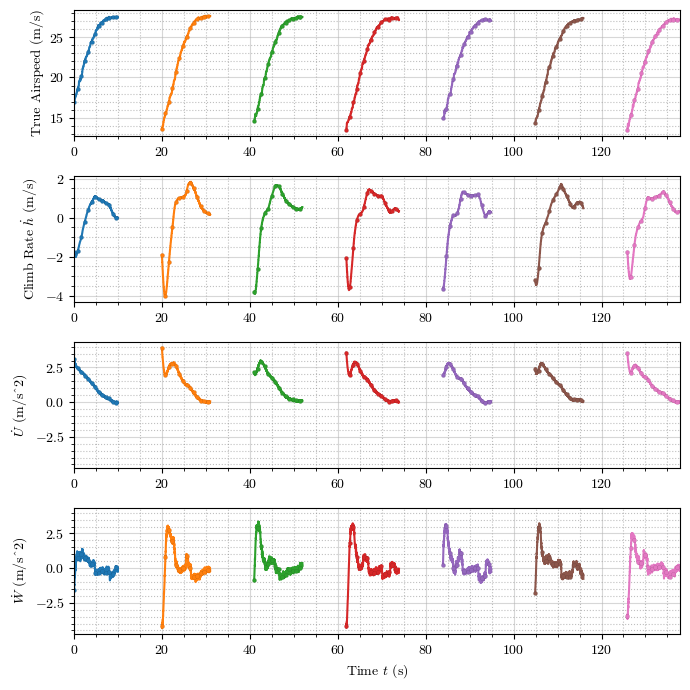

In [70]:
# Plotting Acceleration Runs
markerstyle = 'o'
markerevery = 80
markedgew = 0.05
plt.figure(figsize=(7,7))
ax1 = plt.subplot(4,1,1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax1.plot(time_s, v_tas[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax1.set_ylabel("True Airspeed (m/s)")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
ax1.autoscale(enable=True, axis='x', tight=True)

ax0 = plt.subplot(4,1,2, sharex=ax1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax0.plot(time_s, Vd_tas[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax0.set_ylabel("Climb Rate $\dot{h}$ (m/s)")
ax0.grid(which='major', linestyle='-')
ax0.grid(which='minor', linestyle=':', color='grey')
ax0.autoscale(enable=True, axis='x', tight=True)

ax2 = plt.subplot(4,1,3, sharex=ax1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax2.plot(time_s, U_dot[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax2.set_ylabel("$\dot{U}$ (m/s^2)")
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')
ax2.autoscale(enable=True, axis='x', tight=True)

ax3 = plt.subplot(4,1,4, sharex=ax1, sharey=ax2)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax3.plot(time_s, W_dot[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax3.set_ylabel("$\dot{W}$ (m/s^2)")
ax3.set_xlabel("Time $t$ (s)")
ax3.grid(which='major', linestyle='-')
ax3.grid(which='minor', linestyle=':', color='grey')
ax3.autoscale(enable=True, axis='x', tight=True)

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


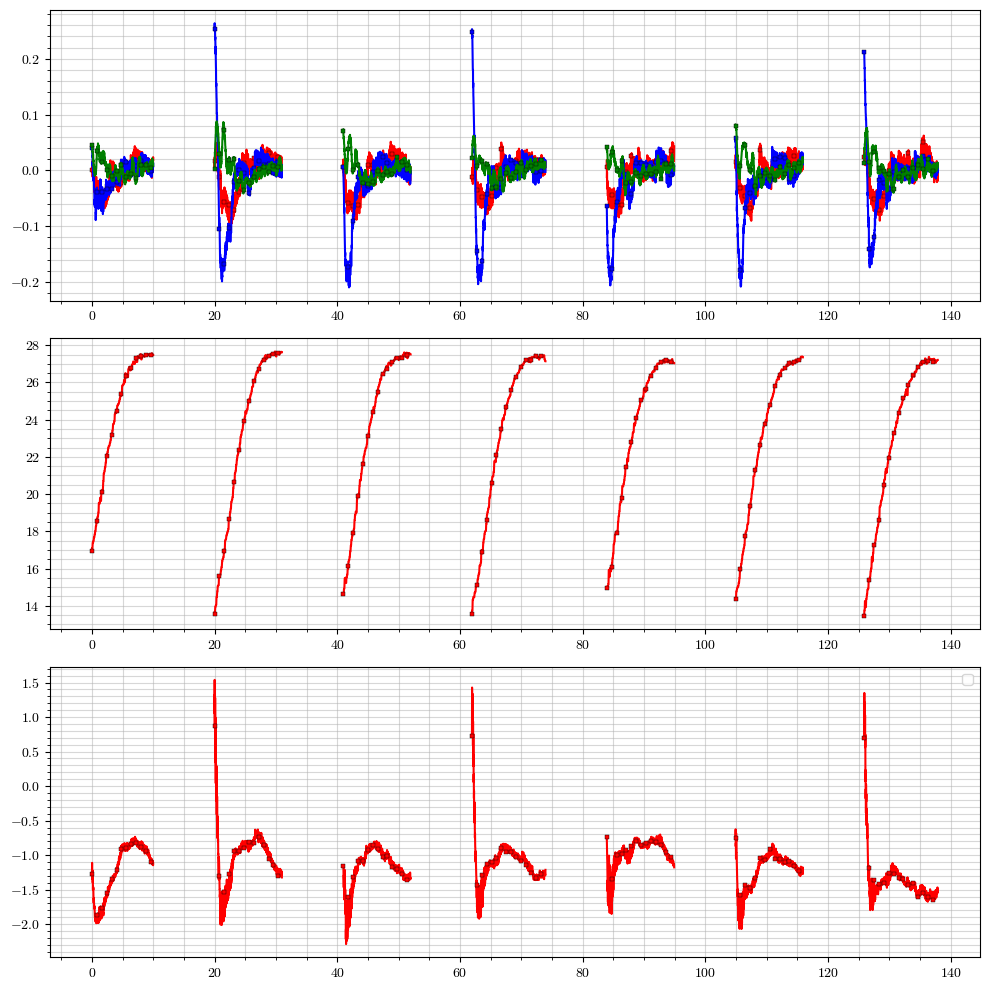

In [71]:
# Plotting the Rotational Rates
plt.figure(figsize=(10,10))
plt.tight_layout()
t_init = 0
markerstyle='s'
markerevery=80
markedgew=0.3

ax1 = plt.subplot(3,1,1)
ax2 = plt.subplot(3,1,2, sharex=ax1)
ax3 = plt.subplot(3,1,3, sharex=ax1)
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax1.plot(time_s, P[masks[i]], color='r', marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, label='P')
    ax1.plot(time_s, Q[masks[i]], color='b', marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, label='Q')
    ax1.plot(time_s, R[masks[i]], color='g', marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, label='R')
    
    ax2.plot(time_s, v_tas[masks[i]], color='r', marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    ax3.plot(time_s, np.rad2deg(alpha[masks[i]]), color='r', marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax1.grid(True)
ax2.grid(True)
plt.legend()
plt.show()

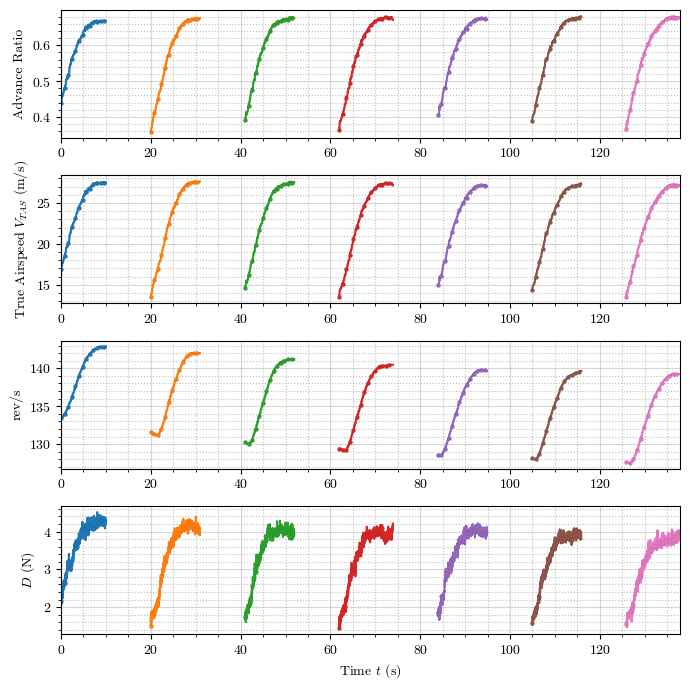

In [72]:
# Plotting Acceleration Runs
markerstyle = 'o'
markerevery = 80
markedgew = 0.05
plt.figure(figsize=(7,7))
ax1 = plt.subplot(4,1,1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax1.plot(time_s, J[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax1.set_ylabel("Advance Ratio")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
ax1.autoscale(enable=True, axis='x', tight=True)

ax0 = plt.subplot(4,1,2, sharex=ax1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax0.plot(time_s, v_tas[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax0.set_ylabel("True Airspeed $V_{TAS}$ (m/s)")
ax0.grid(which='major', linestyle='-')
ax0.grid(which='minor', linestyle=':', color='grey')
ax0.autoscale(enable=True, axis='x', tight=True)

ax2 = plt.subplot(4,1,3, sharex=ax1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax2.plot(time_s, n[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax2.set_ylabel("rev/s")
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')
ax2.autoscale(enable=True, axis='x', tight=True)

ax3 = plt.subplot(4,1,4, sharex=ax1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax3.plot(time_s, D[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax3.set_ylabel("$D$ (N)")
ax3.set_xlabel("Time $t$ (s)")
ax3.grid(which='major', linestyle='-')
ax3.grid(which='minor', linestyle=':', color='grey')
ax3.autoscale(enable=True, axis='x', tight=True)

plt.tight_layout()
plt.show()